<a href="https://colab.research.google.com/github/ariorzk/sibi-coral/blob/main/sibi_recognition_efficientnetv2s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIBI Alphabet Classifier for Edge TPU

This notebook contains the code to train Machine Learning model to recognize Sistem Isyarat Bahasa Indonesia (SIBI) or Indonesian sign language. The model is limited to only recognizing static alphabet of SIBI and not other kind of sign such as words, phrases, or numbers.

## Importing the dataset

For this purpose, I am using premade dataset from Kaggle titled 'Sistem Isyarat Bahasa Indonesia (SIBI)' by Alvin Bintang. This dataset contains 220 images for each static alphabets (everything except j and z) totaling 5280 images.

The codes below are intended for importing Kaggle dataset to Google Colab. If you have your own dataset or you're working on local machine with Jupyter Notebook or other applications, you can safely skip this section.

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download "alvinbintang/sibi-dataset"

100% 2.69G/2.70G [00:17<00:00, 165MB/s]
100% 2.70G/2.70G [00:17<00:00, 164MB/s]


In [ ]:
!unzip sibi-dataset.zip

In [7]:
!pip install split-folders

import splitfolders

splitfolders.ratio('SIBI', output="output", seed=1337, ratio=(0.8, 0.1, 0.1)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 5280 files [00:11, 455.51 files/s]


In [8]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import numpy as np
import matplotlib.pyplot as plt

In [9]:
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/output/test'

In [15]:
from keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 4224 images belonging to 24 classes.
Found 528 images belonging to 24 classes.
Found 528 images belonging to 24 classes.


In [16]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 24))

In [12]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('sibi_labels.txt', 'w') as f:
  f.write(labels)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


In [13]:
! cat sibi_labels.txt

A
B
C
D
E
F
G
H
I
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y

In [17]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.EfficientNetV2S(input_shape=IMG_SHAPE,
                                                    include_top=False, 
                                                    weights='imagenet',
                                                   include_preprocessing=False)
base_model.trainable = False

82420632/82420632 [==============================] - 0s 0us/step


In [18]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=24, activation='softmax')
])

In [19]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
Total params: 20,700,824
Trainable params: 369,464
Non-t

In [21]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


In [22]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
132/132 [==============================] - 593s 4s/step - loss: 1.6668 - accuracy: 0.5073 - val_loss: 0.7151 - val_accuracy: 0.7992
Epoch 2/10
132/132 [==============================] - 581s 4s/step - loss: 0.5490 - accuracy: 0.8222 - val_loss: 0.3590 - val_accuracy: 0.8883
Epoch 3/10
132/132 [==============================] - 590s 4s/step - loss: 0.3497 - accuracy: 0.8899 - val_loss: 0.2286 - val_accuracy: 0.9337
Epoch 4/10
132/132 [==============================] - 593s 4s/step - loss: 0.2437 - accuracy: 0.9228 - val_loss: 0.2253 - val_accuracy: 0.9053
Epoch 5/10
132/132 [==============================] - 594s 4s/step - loss: 0.1879 - accuracy: 0.9455 - val_loss: 0.1317 - val_accuracy: 0.9527
Epoch 6/10
132/132 [==============================] - 609s 5s/step - loss: 0.1746 - accuracy: 0.9479 - val_loss: 0.1275 - val_accuracy: 0.9545
Epoch 7/10
132/132 [==============================] - 608s 5s/step - loss: 0.1544 - accuracy: 0.9482 - val_loss: 0.1433 - val_accuracy: 0.9621

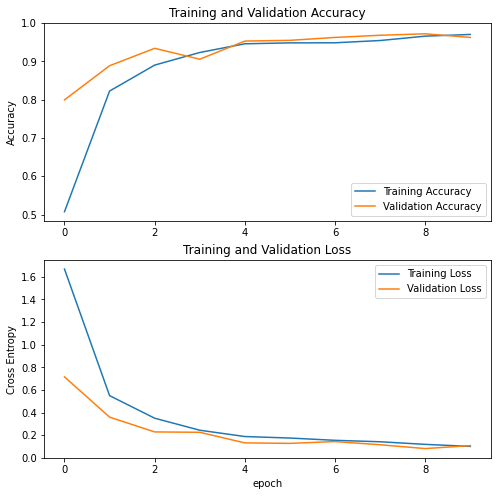

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  512


In [37]:
base_model.trainable = True
fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
Total params: 20,700,824
Trainable params: 8,129,272
Non

In [40]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 101


In [41]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
132/132 [==============================] - 770s 6s/step - loss: 0.4808 - accuracy: 0.8594 - val_loss: 0.2347 - val_accuracy: 0.9280
Epoch 2/5
132/132 [==============================] - 764s 6s/step - loss: 0.3233 - accuracy: 0.9077 - val_loss: 0.1672 - val_accuracy: 0.9527
Epoch 3/5
132/132 [==============================] - 764s 6s/step - loss: 0.2152 - accuracy: 0.9349 - val_loss: 0.1323 - val_accuracy: 0.9583
Epoch 4/5
132/132 [==============================] - 777s 6s/step - loss: 0.1845 - accuracy: 0.9413 - val_loss: 0.1107 - val_accuracy: 0.9678
Epoch 5/5
132/132 [==============================] - 769s 6s/step - loss: 0.1428 - accuracy: 0.9510 - val_loss: 0.1015 - val_accuracy: 0.9659


In [56]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(train_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('efficientnet_v2_small_1.0_224_quant_sibi.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [44]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 90.625%


In [57]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  # input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('efficientnet_v2_small_1.0_224_quant_sibi.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


Quant TF Lite accuracy: 93.750%


In [47]:
test = model.evaluate(test_generator)

17/17 [==============================] - 72s 4s/step - loss: 0.1467 - accuracy: 0.9470


In [48]:
pred = model.predict(test_generator)
pred = tf.nn.softmax(pred)

output = np.argmax(pred, axis=1)
labels = test_generator.class_indices
print(labels)
print(type(labels))

pred_labels = dict((v,k) for k,v in labels.items())
print(pred_labels)
print(type(pred_labels))

17/17 [==============================] - 72s 4s/step
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}
<class 'dict'>
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'}
<class 'dict'>


In [49]:
labeled_pred = []
for i in range(0, len(output)):
    labeled_pred.append(pred_labels[output[i]])

labeled_true = []
for i in range(0, len(test_generator.classes)):
    labeled_true.append(pred_labels[test_generator.classes[i]])

              precision    recall  f1-score   support

           A     0.9565    1.0000    0.9778        22
           B     1.0000    0.9091    0.9524        22
           C     0.9565    1.0000    0.9778        22
           D     1.0000    1.0000    1.0000        22
           E     0.9565    1.0000    0.9778        22
           F     0.9167    1.0000    0.9565        22
           G     1.0000    1.0000    1.0000        22
           H     1.0000    1.0000    1.0000        22
           I     0.9000    0.8182    0.8571        22
           K     0.8462    1.0000    0.9167        22
           L     0.9167    1.0000    0.9565        22
           M     0.9500    0.8636    0.9048        22
           N     0.9048    0.8636    0.8837        22
           O     1.0000    1.0000    1.0000        22
           P     0.9500    0.8636    0.9048        22
           Q     1.0000    0.9545    0.9767        22
           R     1.0000    0.9091    0.9524        22
           S     0.9167    

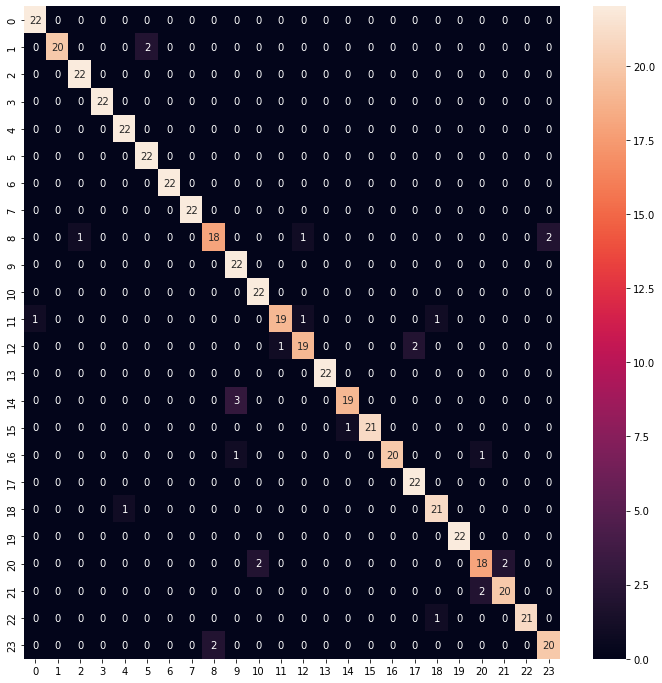

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(labeled_true,labeled_pred,digits=4))
cf_matrix = confusion_matrix(labeled_true, labeled_pred)

plt.figure(figsize=(12,12))
sns.heatmap(cf_matrix,annot=True)

In [52]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  44508      0 --:--:-- --:--:-- --:--:-- 45303
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [3,072 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get

In [60]:
! edgetpu_compiler efficientnet_v2_small_1.0_224_quant_sibi.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.
ERROR: Attempting to use a delegate that only supports static-sized tensors with a graph that has dynamic-sized tensors.
Compilation failed: Model failed in Tflite interpreter. Please ensure model can be loaded/run in Tflite interpreter.
Compilation child process completed within timeout period.
Compilation failed! 


In [ ]:
from google.colab import files

files.download('mobilenet_v3_small_1.0_224_quant_sibi_edgetpu.tflite')
files.download('sibi_labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>